In [46]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import ImageEnhance
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from util import *

In [47]:
vidcap = cv2.VideoCapture("data/train.mp4")
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames, image = vidcap.read()
    if hasFrames:
        cv2.imwrite("data/frames/train/train_thumb_"+str(count)+".jpg", image)
    return hasFrames
sec = 0
frameRate = 0.05  #it will capture image each 0.05 second
count = 1
success = getFrame(sec)
print("converting video to frames")
length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(length)):
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
print("finished")     #generate frames from video

  0%|          | 10/20400 [00:00<03:40, 92.68it/s]

converting video to frames


100%|██████████| 20400/20400 [25:11<00:00, 13.50it/s]

finished


In [48]:
vidcap = cv2.VideoCapture("data/test.mp4")
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames, image = vidcap.read()
    if hasFrames:
        cv2.imwrite("data/frames/test/test_thumb_"+str(count)+".jpg", image)
    return hasFrames
sec = 0
frameRate = 0.05  #it will capture image each 0.05 second
count = 1
success = getFrame(sec)
print("converting video to frames")
testLength = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm(range(testLength)):
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
print("finished")     #generate frames from video

  0%|          | 8/10798 [00:00<02:33, 70.14it/s]

converting video to frames


100%|██████████| 10798/10798 [13:36<00:00, 13.22it/s]

finished


In [49]:
##Train test split
ratio = 0.8
trainset, i = [], 0
with open("data/train.txt", 'r') as file:
    content = file.read().splitlines()
print("length of train label: " + str(len(content)))
while i < len(content)-1:
    trainset.append(["data/frames/train/train_thumb_"+str(i+1)+".jpg",\
              "data/frames/train/train_thumb_"+str(i+2)+".jpg", float(content[i+1])])
    i += 1

df = pd.DataFrame(trainset, columns=["img1","img2","speed"])
heldout = df.iloc[-1200:]
trainval = df.iloc[:-1200]
train = trainval.sample(frac=float(ratio),random_state=200)
val = trainval.drop(train.index)

test_set = []
for i in range(testLength - 1):
    test_set.append(["data/frames/test/test_thumb_"+str(i+1)+".jpg",
                     "data/frames/test/test_thumb_"+str(i+2)+".jpg",
                   None])
    
test = pd.DataFrame(test_set, columns=["img1", "img2", "speed"])
print("train data length after ratio split: " + str(len(train)))
print("test data length after ratio split: " + str(len(test)))
train.to_csv("data/train.csv")
test.to_csv("data/test.csv")
val.to_csv("data/val.csv")
heldout.to_csv("data/heldout.csv")    #Splite ratio as argument

length of train label: 20400
train data length after ratio split: 15519
test data length after ratio split: 10797


In [70]:
def opticalFlowDense(image_current, image_next):
    img_front = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    img_back = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(img_front, img_back, None, 0.5, 1, 15, 2, 5, 1.3, 0)
    return flow

In [71]:
class preProcess(Dataset):

    def __init__(self, csv_file, augment=True, normalize=None):
        self.df = pd.read_csv(csv_file)
        self.augment = augment
        self.normalize = normalize
        self.train = train
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img1 = Image.open(row['img1']).crop((0, 170, 640, 370)).resize((160,50))
        img2 = Image.open(row['img2']).crop((0, 170, 640, 370)).resize((160,50))
        if self.augment:
            brightness = np.random.uniform(0.2, 2)
            img1 = ImageEnhance.Brightness(img1).enhance(brightness)
            img2 = ImageEnhance.Brightness(img2).enhance(brightness)            

            color = np.random.uniform(0.2, 2)
            img1 = ImageEnhance.Color(img1).enhance(color)
            img2 = ImageEnhance.Color(img2).enhance(color)   
            
            flip = np.random.uniform(0, 1)
            if flip < 0.5:
                img1 = img1.transpose(Image.FLIP_LEFT_RIGHT)
                img2 = img2.transpose(Image.FLIP_LEFT_RIGHT)
            
        img1 = np.asarray(img1)
        img2 = np.asarray(img2)
        flow = opticalFlowDense(img1, img2)
        return TF.to_tensor(flow), row['speed']


In [72]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.input_norm = nn.BatchNorm2d(2)

        self.conv1 = nn.Conv2d(2, 3, kernel_size=(5,5), stride=(2,2), padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(3)    

        resnet = list(models.resnet18(pretrained=True).children())[:-4] 
        self.resnet = nn.Sequential(*resnet)

        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), stride=(2,2), padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 3, 64, bias=True)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32, bias=True)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ELU()
        
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        
    def forward(self, out):
        out = self.input_norm(out)
        out = self.relu(self.bn1(self.conv1(out)))
        out = self.resnet(out)
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.relu(self.bn3(self.conv3(out)))
        out = out.view(-1, 64 * 3)
        out = self.relu(self.dp1(self.bn4(self.fc1(out))))
        out = self.relu(self.dp2(self.bn5(self.fc2(out))))
        out = self.fc3(out)
        return out
    


In [73]:
def train(train_loader, model, optimizer):
    model.train()
    real = np.asarray([])
    predicted = np.asarray([])

    for i, data in enumerate(tqdm(train_loader, leave=False)):
        img, speed = data
        img, speed = img.to(device), speed.float().to(device)

        y = model(img)
        loss = ((y.view(-1) - speed)**2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        real = np.append(real, speed.cpu().numpy())
        predicted = np.append(predicted, y.detach().cpu().numpy())
    return real, predicted

def test(heldout_loader, model):
    model.eval()
    real = np.asarray([])
    predicted = np.asarray([])
    for i, data in enumerate(tqdm(heldout_loader, leave=False)):
        img, speed = data
        img, speed = img.to(device), speed.float().to(device)

        y = model(img)

        real = np.append(real, speed.cpu().numpy())
        predicted = np.append(predicted, y.detach().cpu().numpy())
    return real, predicted

In [74]:
train_dataset = preProcess(csv_file='data/train.csv', augment=True)
val_dataset = preProcess(csv_file='data/val.csv', augment=False)
heldout_dataset = preProcess(csv_file='data/heldout.csv', augment=False)
test_dataset = preProcess(csv_file='data/test.csv', augment=False)
if torch.cuda.is_available():  
  deviceName = "cuda:0" 
else:  
  deviceName = "cpu" 
device = torch.device(deviceName)
model = CNN().to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [75]:
best_val_loss = float('inf')
best_heldout_loss = float('inf')
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)
heldout_loader = DataLoader(heldout_dataset, batch_size=32, num_workers=4, shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
losses = []

In [163]:
for iteration in range(1, 40):
    val_loss = []

    model.train()
    train_real, train_predicted = train(train_loader,model, optimizer)
    train_loss = ((train_real - train_predicted)**2).mean()
    val_real, val_predicted = test(val_loader, model)
    val_loss = ((val_real - val_predicted)**2).mean()
    curr_val_min = findMinLoss(val_real, val_predicted)
    heldout_real, heldout_predicted = test(heldout_loader, model)
    heldout_loss = ((heldout_real - heldout_predicted)**2).mean()
    curr_heldout_min = findMinLoss(heldout_real, heldout_predicted)
    
    checkpoint = {"model_state_dict": model.state_dict(),"iteration" : iteration,"loss" : (curr_val_min, curr_heldout_min),"optimizer" : optimizer.state_dict()}

    if curr_val_min < best_val_loss:
        torch.save(checkpoint, "min_val.pth")
        best_val_loss = curr_val_min

    if curr_heldout_min < best_heldout_loss:
        torch.save(checkpoint, "min_heldout.pth")
        best_heldout_loss = curr_heldout_min
        
    print(iteration + 1, train_loss, "\t", val_loss, curr_val_min, "\t", heldout_loss, curr_heldout_min)
    losses.append((train_loss, val_loss, heldout_loss))

print("finished")

  0%|          | 0/485 [00:00<?, ?it/s]          

2 11.93722653642987 	 5.398306976500009 4.59734885578571 	 2.7328325225567025 1.9328579838724789


  0%|          | 0/485 [00:00<?, ?it/s]          

3 11.237208025453658 	 8.951174285402306 8.152910520887707 	 2.7610358426491612 2.0672828842112203


  0%|          | 0/485 [00:00<?, ?it/s]          

4 11.417458237064073 	 4.944052721319574 4.188025135387742 	 3.832438288711377 2.9873302083979594


  0%|          | 0/485 [00:00<?, ?it/s]          

5 11.0877593453064 	 6.056085037617574 5.181105909164727 	 2.753614064970798 1.9925069738760204


  0%|          | 0/485 [00:00<?, ?it/s]          

6 11.103167951229096 	 6.682078649697156 5.829516420339186 	 2.1129852153984774 1.4539641615507723


  0%|          | 0/485 [00:00<?, ?it/s]          

7 10.98865653346467 	 6.096266558154887 5.285796753688656 	 2.3838467506268644 1.7785183144265693


  0%|          | 0/485 [00:00<?, ?it/s]          

8 10.92347395298546 	 5.252549365160856 4.579327315539095 	 2.1459662765775454 1.631955850015664


  0%|          | 0/485 [00:00<?, ?it/s]          

9 11.14296057204252 	 6.71503022433185 5.940618799022213 	 1.7347652473767863 1.1153662319033046


10 11.073662053781327 	 7.364415957605203 6.549783193218085 	 2.0668468559181883 1.3826781777983215
finished


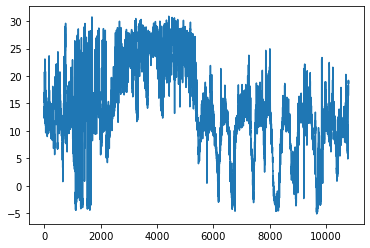

In [164]:
#original output
testLoader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)
dummy, testPredict = test(testLoader, model)
##30iter, iloc[:1000]
plt.figure()
plt.plot(testPredict)
plt.show()


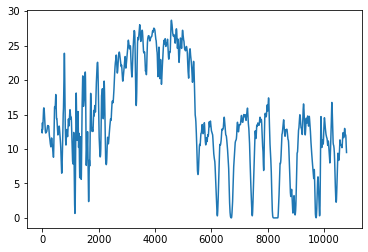

In [176]:
#noise reduction
res2 = testPredict
for i in range(len(res2) - 2):
    res2[i+2] = (res2[i] + res2[i+1] + res2[i+2])/3
    if res2[i] < 0:
        res2[i] = 0

plt.figure()
plt.plot(res2)
plt.show()

In [177]:
np.savetxt("test.txt", res2)